Importar Librerias  

In [3]:
# gestión de datos
import numpy as np
import pandas as pd
import math

# fechas
import datetime as dt
from datetime import datetime
from dateutil.relativedelta import relativedelta

# gráficos
import seaborn as sns
import matplotlib.pyplot as plt
import jinja2

# preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

# modelos
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier

# metricas
import sklearn.metrics as metrics

# interpretabilidad
import shap

# hiperparametrizado
from sklearn.model_selection import GridSearchCV

# quitar alertas
import warnings
warnings.filterwarnings("ignore")


In [4]:
df = pd.read_csv('./DATA/pedidos_entrenar.csv')
df_pred = pd.read_csv("./DATA/pedidos_predecir.csv")

In [5]:
df.head(1)

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total,final_status
0,33446280,14:11:09,AR,55379,PAID,2,11.88,DeliveredStatus


In [6]:
df["payment_status"].value_counts()

payment_status
PAID        53854
NOT_PAID      470
DELAYED         6
Name: count, dtype: int64

In [7]:
for i in df:
    print("Value_counts",df[i].value_counts(),"\n")
    print("Unique",df[i].unique(),"\n")

Value_counts order_id
33446280    1
32766208    1
32869927    1
32137313    1
32609872    1
           ..
32363605    1
33439367    1
32773775    1
32655367    1
32695191    1
Name: count, Length: 54330, dtype: int64 

Unique [33446280 33107339 32960645 ... 32895248 32792276 32695191] 

Value_counts local_time
09:03:01    38
10:03:06    31
10:03:05    26
10:03:01    25
10:03:02    24
            ..
18:16:53     1
21:36:02     1
11:42:25     1
09:42:03     1
12:21:30     1
Name: count, Length: 32905, dtype: int64 

Unique ['14:11:09' '11:47:41' '11:53:53' ... '23:12:31' '13:24:05' '12:21:30'] 

Value_counts country_code
AR    11854
ES    11554
TR     5696
PE     4284
UA     3729
IT     2537
EC     2265
RO     1957
FR     1911
EG     1643
MA     1446
CR     1000
CL      994
PA      909
PT      818
GT      511
GE      485
DO      448
UY      169
KE       84
PR       29
CI        6
BR        1
Name: count, dtype: int64 

Unique ['AR' 'GT' 'CR' 'ES' 'PE' 'PA' 'FR' 'IT' 'TR' 'EC' 'RO' 'KE' '

In [8]:
df.isnull().sum()

order_id          0
local_time        0
country_code      0
store_address     0
payment_status    0
n_of_products     0
products_total    0
final_status      0
dtype: int64

In [9]:
df_pred.isnull().sum()

order_id          0
local_time        0
country_code      0
store_address     0
payment_status    0
n_of_products     0
products_total    0
dtype: int64

In [10]:
df.duplicated().sum()

0

In [11]:
df_pred.duplicated().sum()

0

## pasamos Local_Time a fecha hora

In [12]:
df["local_time"] = pd.to_datetime(df["local_time"])

In [13]:
df["hora_compra"] = df["local_time"].dt.hour

In [14]:
df_pred["local_time"] = pd.to_datetime(df_pred["local_time"])

In [15]:
df_pred["hora_compra"] = df_pred["local_time"].dt.hour

In [16]:
df.nunique()

order_id          54330
local_time        32905
country_code         23
store_address      5627
payment_status        3
n_of_products        27
products_total     3904
final_status          2
hora_compra          24
dtype: int64

In [17]:
del(df["local_time"])
del(df_pred["local_time"])

In [18]:
df

,order_id,country_code,store_address,payment_status,n_of_products,products_total,final_status,hora_compra
0,33446280,AR,55379,PAID,2,11.88,DeliveredStatus,14
1,33107339,GT,23487,PAID,2,5.20,DeliveredStatus,11
2,32960645,CR,62229,PAID,1,6.03,DeliveredStatus,11
3,32089564,ES,29446,PAID,6,6.37,DeliveredStatus,20
4,32157739,AR,13917,PAID,1,5.36,CanceledStatus,21
...,...,...,...,...,...,...,...,...
54325,33443728,AR,63825,PAID,2,10.39,DeliveredStatus,13
54326,33499561,AR,27741,PAID,1,9.07,DeliveredStatus,17
54327,32895248,PA,65895,PAID,2,1.65,DeliveredStatus,20
54328,32792276,ES,20134,PAID,6,8.04,DeliveredStatus,13


### Ahora vamos a tratar la hora de compra no como una variable lineal sino como una variable cíclica. Esto es porque si la tratamos de forma lineal el modelo puede pensar que el las 12 esta en extremos opuesto que la 1...y no es así, son contiguas


In [19]:
# pasamos la variable ciclica a 2 variables con su seno y coseno
df['hora_compra'] = df['hora_compra'] * 2 * math.pi / 24
df_pred['hora_compra'] = df_pred['hora_compra'] * 2 * math.pi / 24

df['hora_compra_cos'] = df['hora_compra'].apply(lambda x: math.cos(x))
df_pred['hora_compra_cos'] = df_pred['hora_compra'].apply(lambda x: math.cos(x))
df['hora_compra_sin'] = df['hora_compra'].apply(lambda x: math.sin(x))
df_pred['hora_compra_sin'] = df_pred['hora_compra'].apply(lambda x: math.sin(x))

df = df.drop('hora_compra', axis=True)
df_pred = df_pred.drop('hora_compra', axis=True)

In [20]:
df

,order_id,country_code,store_address,payment_status,n_of_products,products_total,final_status,hora_compra_cos,hora_compra_sin
0,33446280,AR,55379,PAID,2,11.88,DeliveredStatus,-0.866025,-5.000000e-01
1,33107339,GT,23487,PAID,2,5.20,DeliveredStatus,-0.965926,2.588190e-01
2,32960645,CR,62229,PAID,1,6.03,DeliveredStatus,-0.965926,2.588190e-01
3,32089564,ES,29446,PAID,6,6.37,DeliveredStatus,0.500000,-8.660254e-01
4,32157739,AR,13917,PAID,1,5.36,CanceledStatus,0.707107,-7.071068e-01
...,...,...,...,...,...,...,...,...,...
54325,33443728,AR,63825,PAID,2,10.39,DeliveredStatus,-0.965926,-2.588190e-01
54326,33499561,AR,27741,PAID,1,9.07,DeliveredStatus,-0.258819,-9.659258e-01
54327,32895248,PA,65895,PAID,2,1.65,DeliveredStatus,0.500000,-8.660254e-01
54328,32792276,ES,20134,PAID,6,8.04,DeliveredStatus,-0.965926,-2.588190e-01


## Categoricas

In [21]:
df["final_status"] = np.where(df["final_status"] == "DeliveredStatus", 1, 0) #Cambiamos la variable target a 1 si esta entregado y 0 si no se entrega

In [22]:
# Tb podríamos hacerlo asi :
#df['final_status'] = df['final_status'].apply(lambda x: 1 if x == 'DeliveredStatus'  else 0)

In [23]:
df["final_status"] 


0        1
1        1
2        1
3        1
4        0
        ..
54325    1
54326    1
54327    1
54328    1
54329    1
Name: final_status, Length: 54330, dtype: int32

### country_code

In [24]:
#  comprobamos el % de representación de cada valor de la variable con value_counts
df["country_code"].value_counts(normalize=True)

country_code
AR    0.218185
ES    0.212663
TR    0.104841
PE    0.078851
UA    0.068636
IT    0.046696
EC    0.041690
RO    0.036021
FR    0.035174
EG    0.030241
MA    0.026615
CR    0.018406
CL    0.018296
PA    0.016731
PT    0.015056
GT    0.009405
GE    0.008927
DO    0.008246
UY    0.003111
KE    0.001546
PR    0.000534
CI    0.000110
BR    0.000018
Name: proportion, dtype: float64

In [25]:
# creamos un df auxiliar con la frecuencia y frecuencia acumulada de cada codigo de pais
df_region = df["country_code"].value_counts(normalize=True).to_frame().reset_index()

In [26]:
df_region

,country_code,proportion
0,AR,0.218185
1,ES,0.212663
2,TR,0.104841
3,PE,0.078851
4,UA,0.068636
5,IT,0.046696
6,EC,0.041690
7,RO,0.036021
8,FR,0.035174
9,EG,0.030241


In [27]:
df_region.columns = ["country_code","frecuencia"]

In [28]:
# añado columnna con frecuencia acumulada
df_region["frecuencia_acumulada"] = df_region["frecuencia"].cumsum()

In [29]:
df_region["frecuencia_acumulada"] = df_region["frecuencia_acumulada"].apply(lambda x: x*100).round(1)

In [30]:
df_region

,country_code,frecuencia,frecuencia_acumulada
0,AR,0.218185,21.8
1,ES,0.212663,43.1
2,TR,0.104841,53.6
3,PE,0.078851,61.5
4,UA,0.068636,68.3
5,IT,0.046696,73.0
6,EC,0.041690,77.2
7,RO,0.036021,80.8
8,FR,0.035174,84.3
9,EG,0.030241,87.3


In [31]:
df_region.loc[df_region["frecuencia_acumulada"] >= 90, "country_code"] = "otro"


In [32]:
df_region

,country_code,frecuencia,frecuencia_acumulada
0,AR,0.218185,21.8
1,ES,0.212663,43.1
2,TR,0.104841,53.6
3,PE,0.078851,61.5
4,UA,0.068636,68.3
5,IT,0.046696,73.0
6,EC,0.041690,77.2
7,RO,0.036021,80.8
8,FR,0.035174,84.3
9,EG,0.030241,87.3


In [33]:
df_region["country_code"][df_region["country_code"]!= "otro"]

0    AR
1    ES
2    TR
3    PE
4    UA
5    IT
6    EC
7    RO
8    FR
9    EG
Name: country_code, dtype: object

In [34]:
Lista_paises_frecuentes =list(df_region["country_code"][df_region["country_code"]!= "otro"])

In [35]:
Lista_paises_frecuentes

['AR', 'ES', 'TR', 'PE', 'UA', 'IT', 'EC', 'RO', 'FR', 'EG']

In [36]:
df["country_code"] = df["country_code"].apply(lambda x: x if x in Lista_paises_frecuentes else "otro")

In [37]:
df_pred["country_code"] = df_pred["country_code"].apply(lambda x: x if x in Lista_paises_frecuentes else "otro")

In [38]:
df

,order_id,country_code,store_address,payment_status,n_of_products,products_total,final_status,hora_compra_cos,hora_compra_sin
0,33446280,AR,55379,PAID,2,11.88,1,-0.866025,-5.000000e-01
1,33107339,otro,23487,PAID,2,5.20,1,-0.965926,2.588190e-01
2,32960645,otro,62229,PAID,1,6.03,1,-0.965926,2.588190e-01
3,32089564,ES,29446,PAID,6,6.37,1,0.500000,-8.660254e-01
4,32157739,AR,13917,PAID,1,5.36,0,0.707107,-7.071068e-01
...,...,...,...,...,...,...,...,...,...
54325,33443728,AR,63825,PAID,2,10.39,1,-0.965926,-2.588190e-01
54326,33499561,AR,27741,PAID,1,9.07,1,-0.258819,-9.659258e-01
54327,32895248,otro,65895,PAID,2,1.65,1,0.500000,-8.660254e-01
54328,32792276,ES,20134,PAID,6,8.04,1,-0.965926,-2.588190e-01


In [39]:
df_pred

,order_id,country_code,store_address,payment_status,n_of_products,products_total,hora_compra_cos,hora_compra_sin
0,32240990,ES,8220,REFOUND,11,15.99,-1.836970e-16,-1.000000
1,32960491,otro,32273,NOT_PAID,2,1.79,-1.836970e-16,-1.000000
2,32430153,otro,17782,PAID,5,29.89,-9.659258e-01,-0.258819
3,32777553,TR,28205,PAID,1,1.47,-7.071068e-01,0.707107
4,32324328,AR,64309,PAID,1,4.20,7.071068e-01,-0.707107
5,33047576,UA,61562,PAID,6,18.73,-9.659258e-01,0.258819
6,33293677,ES,22022,PAID,1,3.80,5.000000e-01,-0.866025
7,32073867,otro,48440,PAID,1,6.25,-8.660254e-01,-0.500000
8,32732256,ES,18667,PAID,2,14.50,7.071068e-01,-0.707107
9,32152540,EC,41406,PAID,1,21.10,-1.836970e-16,-1.000000


### Store Address: Variable categórica que aparece en forma numérica

In [40]:
'''NO POR MAS ALTO EL CODIGO DE DIRECCION MAS ALTO EL TARGET'''

'NO POR MAS ALTO EL CODIGO DE DIRECCION MAS ALTO EL TARGET'

In [41]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [42]:
from category_encoders import TargetEncoder

In [43]:
# Paso 1: calcular el número de envíos por tienda
frecuencia = df['store_address'].value_counts()

# Paso 2: crear un booleano para detectar las tiendas con menos de 10 envíos
tiendas_poco_frecuentes = frecuencia[frecuencia < 10].index

# Paso 3: filtrar el dataframe original
df_menos_de_10_envios = df[df['store_address'].isin(tiendas_poco_frecuentes)]


In [44]:
len(tiendas_poco_frecuentes) #tiendas_poco_frecuentes

4059

In [45]:
# nos aseguramos que sea categorica
df['store_address'] = df['store_address'].astype('category')
df_pred['store_address'] = df_pred['store_address'].astype('category')

In [46]:
# primero hago fit_transform para conocer la media de la target del dataset de entrenamiento
# despues hago el transform para cambiar el valor de la categoría del dataset a predecir por la media calculada en el dataset de entrenamiento
codificador = TargetEncoder(smoothing=15)
df['store_address'] = codificador.fit_transform(df['store_address'], df['final_status'])
df_pred['store_address'] = codificador.transform(df_pred['store_address'])

In [47]:
df

,order_id,country_code,store_address,payment_status,n_of_products,products_total,final_status,hora_compra_cos,hora_compra_sin
0,33446280,AR,0.920140,PAID,2,11.88,1,-0.866025,-5.000000e-01
1,33107339,otro,0.849705,PAID,2,5.20,1,-0.965926,2.588190e-01
2,32960645,otro,0.861223,PAID,1,6.03,1,-0.965926,2.588190e-01
3,32089564,ES,0.976403,PAID,6,6.37,1,0.500000,-8.660254e-01
4,32157739,AR,0.831298,PAID,1,5.36,0,0.707107,-7.071068e-01
...,...,...,...,...,...,...,...,...,...
54325,33443728,AR,0.917503,PAID,2,10.39,1,-0.965926,-2.588190e-01
54326,33499561,AR,0.973936,PAID,1,9.07,1,-0.258819,-9.659258e-01
54327,32895248,otro,0.902471,PAID,2,1.65,1,0.500000,-8.660254e-01
54328,32792276,ES,0.856131,PAID,6,8.04,1,-0.965926,-2.588190e-01


In [48]:
df_pred

,order_id,country_code,store_address,payment_status,n_of_products,products_total,hora_compra_cos,hora_compra_sin
0,32240990,ES,0.946932,REFOUND,11,15.99,-1.836970e-16,-1.000000
1,32960491,otro,0.801766,NOT_PAID,2,1.79,-1.836970e-16,-1.000000
2,32430153,otro,0.960532,PAID,5,29.89,-9.659258e-01,-0.258819
3,32777553,TR,0.937050,PAID,1,1.47,-7.071068e-01,0.707107
4,32324328,AR,0.842784,PAID,1,4.20,7.071068e-01,-0.707107
5,33047576,UA,0.922954,PAID,6,18.73,-9.659258e-01,0.258819
6,33293677,ES,0.849705,PAID,1,3.80,5.000000e-01,-0.866025
7,32073867,otro,0.882146,PAID,1,6.25,-8.660254e-01,-0.500000
8,32732256,ES,0.845087,PAID,2,14.50,7.071068e-01,-0.707107
9,32152540,EC,0.908179,PAID,1,21.10,-1.836970e-16,-1.000000


### Order_id

In [49]:
'''ELIMINAMOS ORDER ID '''

'ELIMINAMOS ORDER ID '

In [50]:
'''Lo eliminamos del dataset de entrenamiento y del de predicción(aunque en este ultimo lo guardamos aparte)'''

'Lo eliminamos del dataset de entrenamiento y del de predicción(aunque en este ultimo lo guardamos aparte)'

In [51]:
order_ids = df_pred['order_id']

In [52]:
df.drop('order_id', axis=1, inplace=True)
df_pred.drop('order_id', axis=1, inplace=True)

### payment_status

In [53]:
df['payment_status'].unique()

array(['PAID', 'NOT_PAID', 'DELAYED'], dtype=object)

In [54]:
df_pred['payment_status'].unique()

array(['REFOUND', 'NOT_PAID', 'PAID'], dtype=object)

In [55]:
'''TRATAREMOS MAS TARDE CON ONE HOT ENCODING'''

'TRATAREMOS MAS TARDE CON ONE HOT ENCODING'

## PREPROCESSING
##
### SAMPLE

Para la clasificación, los modelos funcionan mucho mejor con un dataset equilibrados: misma cantidad de 1 que de 0 en la target.  
Sino, aprende muy bien una categoría, pero muy mal la otra.  
Se pierde información, pero la que se tiene es más valiosa para entrenar.

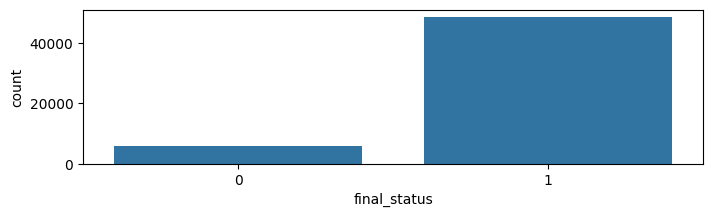

In [56]:
fig, ax = plt.subplots(figsize=(8, 2))
sns.countplot(data=df, x='final_status')
plt.show()

In [57]:
df['final_status'].value_counts()

final_status
1    48498
0     5832
Name: count, dtype: int64

In [58]:
df['final_status'].value_counts(normalize=True).mul(100).round(1)

final_status
1    89.3
0    10.7
Name: proportion, dtype: float64

In [59]:
# se filtran los pedidos entregados y los cancelados
entregados = df[df['final_status'] == 1]
cancelados = df[df['final_status'] == 0]

In [60]:
# se selecciona de forma aleatoria el mismo número de pedidos entregados que cancelados para equilibrar el dataset, sin posibilidad de repetir pedido con sample
entregados = entregados.sample(len(cancelados), replace=False, random_state=42)

In [61]:
# se juntan los dataframes de entregados y cancelados en el df_train con concat
df = pd.concat([entregados, cancelados])

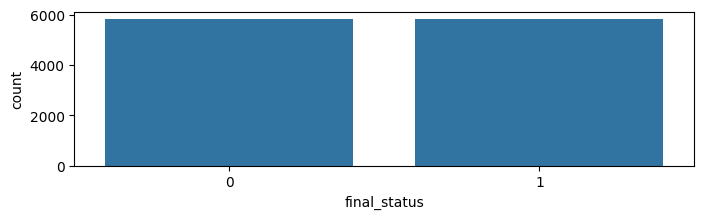

In [62]:
fig, ax = plt.subplots(figsize=(8, 2))
sns.countplot(data=df, x='final_status')
plt.show()

In [63]:
df

,country_code,store_address,payment_status,n_of_products,products_total,final_status,hora_compra_cos,hora_compra_sin
37644,ES,0.928457,PAID,4,6.45,1,-0.500000,-0.866025
19618,TR,0.813949,PAID,2,5.65,1,0.258819,-0.965926
8109,TR,0.986054,PAID,2,7.24,1,0.707107,-0.707107
26542,RO,0.925935,PAID,1,32.68,1,-0.965926,0.258819
6158,otro,0.861223,PAID,13,17.63,1,-0.500000,-0.866025
...,...,...,...,...,...,...,...,...
54258,AR,0.734788,PAID,3,12.53,0,0.258819,-0.965926
54272,FR,0.938335,PAID,1,10.90,0,0.258819,-0.965926
54284,ES,0.640705,PAID,2,21.50,0,0.500000,-0.866025
54290,EG,0.916826,PAID,1,2.01,0,0.500000,-0.866025


## CORRELACIONES

In [64]:
corr = df.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm')

,store_address,n_of_products,products_total,final_status,hora_compra_cos,hora_compra_sin
store_address,1.000000,0.062711,-0.005752,0.524279,-0.010613,-0.024715
n_of_products,0.062711,1.000000,0.369892,0.023292,-0.057288,-0.041395
products_total,-0.005752,0.369892,1.000000,-0.026950,-0.040547,-0.050841
final_status,0.524279,0.023292,-0.026950,1.000000,-0.072777,-0.030228
hora_compra_cos,-0.010613,-0.057288,-0.040547,-0.072777,1.000000,-0.410106
hora_compra_sin,-0.024715,-0.041395,-0.050841,-0.030228,-0.410106,1.000000


In [65]:
'''EL TARGET NO TIENE CASI CORRELACIÓN CON NINGUNA FEATURE: EL MODELO NO SERÁ BUENO '''

'EL TARGET NO TIENE CASI CORRELACIÓN CON NINGUNA FEATURE: EL MODELO NO SERÁ BUENO '

## ONE HOT ENCODING

In [66]:
df = pd.get_dummies(df)
df_pred = pd.get_dummies(df_pred)

In [67]:
df

,store_address,n_of_products,products_total,final_status,hora_compra_cos,hora_compra_sin,country_code_AR,country_code_EC,country_code_EG,country_code_ES,country_code_FR,country_code_IT,country_code_PE,country_code_RO,country_code_TR,country_code_UA,country_code_otro,payment_status_DELAYED,payment_status_NOT_PAID,payment_status_PAID
37644,0.928457,4,6.45,1,-0.500000,-0.866025,False,False,False,True,False,False,False,False,False,False,False,False,False,True
19618,0.813949,2,5.65,1,0.258819,-0.965926,False,False,False,False,False,False,False,False,True,False,False,False,False,True
8109,0.986054,2,7.24,1,0.707107,-0.707107,False,False,False,False,False,False,False,False,True,False,False,False,False,True
26542,0.925935,1,32.68,1,-0.965926,0.258819,False,False,False,False,False,False,False,True,False,False,False,False,False,True
6158,0.861223,13,17.63,1,-0.500000,-0.866025,False,False,False,False,False,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54258,0.734788,3,12.53,0,0.258819,-0.965926,True,False,False,False,False,False,False,False,False,False,False,False,False,True
54272,0.938335,1,10.90,0,0.258819,-0.965926,False,False,False,False,True,False,False,False,False,False,False,False,False,True
54284,0.640705,2,21.50,0,0.500000,-0.866025,False,False,False,True,False,False,False,False,False,False,False,False,False,True
54290,0.916826,1,2.01,0,0.500000,-0.866025,False,False,True,False,False,False,False,False,False,False,False,False,False,True


In [68]:
df_pred.shape

(10, 14)

In [69]:
'''VEMOS QUE DF Y DF_PRED NO TIENEN MISMO NUMERO DE COLUMNAS POR LO QUE LA PREDICCION NOS DARÁ ERROR'''

'VEMOS QUE DF Y DF_PRED NO TIENEN MISMO NUMERO DE COLUMNAS POR LO QUE LA PREDICCION NOS DARÁ ERROR'

In [70]:
col_df_pred = df_pred.columns
col_df_pred

Index(['store_address', 'n_of_products', 'products_total', 'hora_compra_cos',
       'hora_compra_sin', 'country_code_AR', 'country_code_EC',
       'country_code_ES', 'country_code_TR', 'country_code_UA',
       'country_code_otro', 'payment_status_NOT_PAID', 'payment_status_PAID',
       'payment_status_REFOUND'],
      dtype='object')

In [71]:
col_df = df.columns
col_df

Index(['store_address', 'n_of_products', 'products_total', 'final_status',
       'hora_compra_cos', 'hora_compra_sin', 'country_code_AR',
       'country_code_EC', 'country_code_EG', 'country_code_ES',
       'country_code_FR', 'country_code_IT', 'country_code_PE',
       'country_code_RO', 'country_code_TR', 'country_code_UA',
       'country_code_otro', 'payment_status_DELAYED',
       'payment_status_NOT_PAID', 'payment_status_PAID'],
      dtype='object')

In [72]:
# columnas que están en el dataset de entrenamiento pero no están en el dataset de predicción

col_faltantes = []
for col in col_df:
  if col not in col_df_pred:
    col_faltantes.append(col)
col_faltantes

['final_status',
 'country_code_EG',
 'country_code_FR',
 'country_code_IT',
 'country_code_PE',
 'country_code_RO',
 'payment_status_DELAYED']

In [73]:
# elimino la target de la lista

col_faltantes.remove('final_status')

In [74]:
# añadimos las columnas faltantes al dataset de predicción, inputando el valor 0 a toda la columna

for col in col_faltantes:
  df_pred[col] =[0]*len(df_pred)
df_pred

,store_address,n_of_products,products_total,hora_compra_cos,hora_compra_sin,country_code_AR,country_code_EC,country_code_ES,country_code_TR,country_code_UA,country_code_otro,payment_status_NOT_PAID,payment_status_PAID,payment_status_REFOUND,country_code_EG,country_code_FR,country_code_IT,country_code_PE,country_code_RO,payment_status_DELAYED
0,0.946932,11,15.99,-1.836970e-16,-1.000000,False,False,True,False,False,False,False,False,True,0,0,0,0,0,0
1,0.801766,2,1.79,-1.836970e-16,-1.000000,False,False,False,False,False,True,True,False,False,0,0,0,0,0,0
2,0.960532,5,29.89,-9.659258e-01,-0.258819,False,False,False,False,False,True,False,True,False,0,0,0,0,0,0
3,0.937050,1,1.47,-7.071068e-01,0.707107,False,False,False,True,False,False,False,True,False,0,0,0,0,0,0
4,0.842784,1,4.20,7.071068e-01,-0.707107,True,False,False,False,False,False,False,True,False,0,0,0,0,0,0
5,0.922954,6,18.73,-9.659258e-01,0.258819,False,False,False,False,True,False,False,True,False,0,0,0,0,0,0
6,0.849705,1,3.80,5.000000e-01,-0.866025,False,False,True,False,False,False,False,True,False,0,0,0,0,0,0
7,0.882146,1,6.25,-8.660254e-01,-0.500000,False,False,False,False,False,True,False,True,False,0,0,0,0,0,0
8,0.845087,2,14.50,7.071068e-01,-0.707107,False,False,True,False,False,False,False,True,False,0,0,0,0,0,0
9,0.908179,1,21.10,-1.836970e-16,-1.000000,False,True,False,False,False,False,False,True,False,0,0,0,0,0,0


In [75]:
# columnas que están en el dataset de predicción pero no en el dataset de entrenamiento (nueva categoría)

col_sobrantes = []
for col in col_df_pred:
  if col not in col_df:
    col_sobrantes.append(col)
col_sobrantes

['payment_status_REFOUND']

In [76]:
# eliminamos las columnas sobrantes, ya que el modelo no va a entrenar con ellas

df_pred.drop(col_sobrantes, axis=1, inplace=True)

In [77]:
df

,store_address,n_of_products,products_total,final_status,hora_compra_cos,hora_compra_sin,country_code_AR,country_code_EC,country_code_EG,country_code_ES,country_code_FR,country_code_IT,country_code_PE,country_code_RO,country_code_TR,country_code_UA,country_code_otro,payment_status_DELAYED,payment_status_NOT_PAID,payment_status_PAID
37644,0.928457,4,6.45,1,-0.500000,-0.866025,False,False,False,True,False,False,False,False,False,False,False,False,False,True
19618,0.813949,2,5.65,1,0.258819,-0.965926,False,False,False,False,False,False,False,False,True,False,False,False,False,True
8109,0.986054,2,7.24,1,0.707107,-0.707107,False,False,False,False,False,False,False,False,True,False,False,False,False,True
26542,0.925935,1,32.68,1,-0.965926,0.258819,False,False,False,False,False,False,False,True,False,False,False,False,False,True
6158,0.861223,13,17.63,1,-0.500000,-0.866025,False,False,False,False,False,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54258,0.734788,3,12.53,0,0.258819,-0.965926,True,False,False,False,False,False,False,False,False,False,False,False,False,True
54272,0.938335,1,10.90,0,0.258819,-0.965926,False,False,False,False,True,False,False,False,False,False,False,False,False,True
54284,0.640705,2,21.50,0,0.500000,-0.866025,False,False,False,True,False,False,False,False,False,False,False,False,False,True
54290,0.916826,1,2.01,0,0.500000,-0.866025,False,False,True,False,False,False,False,False,False,False,False,False,False,True


In [78]:
df_pred

,store_address,n_of_products,products_total,hora_compra_cos,hora_compra_sin,country_code_AR,country_code_EC,country_code_ES,country_code_TR,country_code_UA,country_code_otro,payment_status_NOT_PAID,payment_status_PAID,country_code_EG,country_code_FR,country_code_IT,country_code_PE,country_code_RO,payment_status_DELAYED
0,0.946932,11,15.99,-1.836970e-16,-1.000000,False,False,True,False,False,False,False,False,0,0,0,0,0,0
1,0.801766,2,1.79,-1.836970e-16,-1.000000,False,False,False,False,False,True,True,False,0,0,0,0,0,0
2,0.960532,5,29.89,-9.659258e-01,-0.258819,False,False,False,False,False,True,False,True,0,0,0,0,0,0
3,0.937050,1,1.47,-7.071068e-01,0.707107,False,False,False,True,False,False,False,True,0,0,0,0,0,0
4,0.842784,1,4.20,7.071068e-01,-0.707107,True,False,False,False,False,False,False,True,0,0,0,0,0,0
5,0.922954,6,18.73,-9.659258e-01,0.258819,False,False,False,False,True,False,False,True,0,0,0,0,0,0
6,0.849705,1,3.80,5.000000e-01,-0.866025,False,False,True,False,False,False,False,True,0,0,0,0,0,0
7,0.882146,1,6.25,-8.660254e-01,-0.500000,False,False,False,False,False,True,False,True,0,0,0,0,0,0
8,0.845087,2,14.50,7.071068e-01,-0.707107,False,False,True,False,False,False,False,True,0,0,0,0,0,0
9,0.908179,1,21.10,-1.836970e-16,-1.000000,False,True,False,False,False,False,False,True,0,0,0,0,0,0


In [79]:
# verificamos que los dataset tienen el mismo número de variables

df_pred.shape[1] == df.shape[1] -1 #el -1 es porque df tiene la columna target

True

## FEATURE IMPORTANCE

averigua las variables más utilizadas en un modelo de árbol de decisión

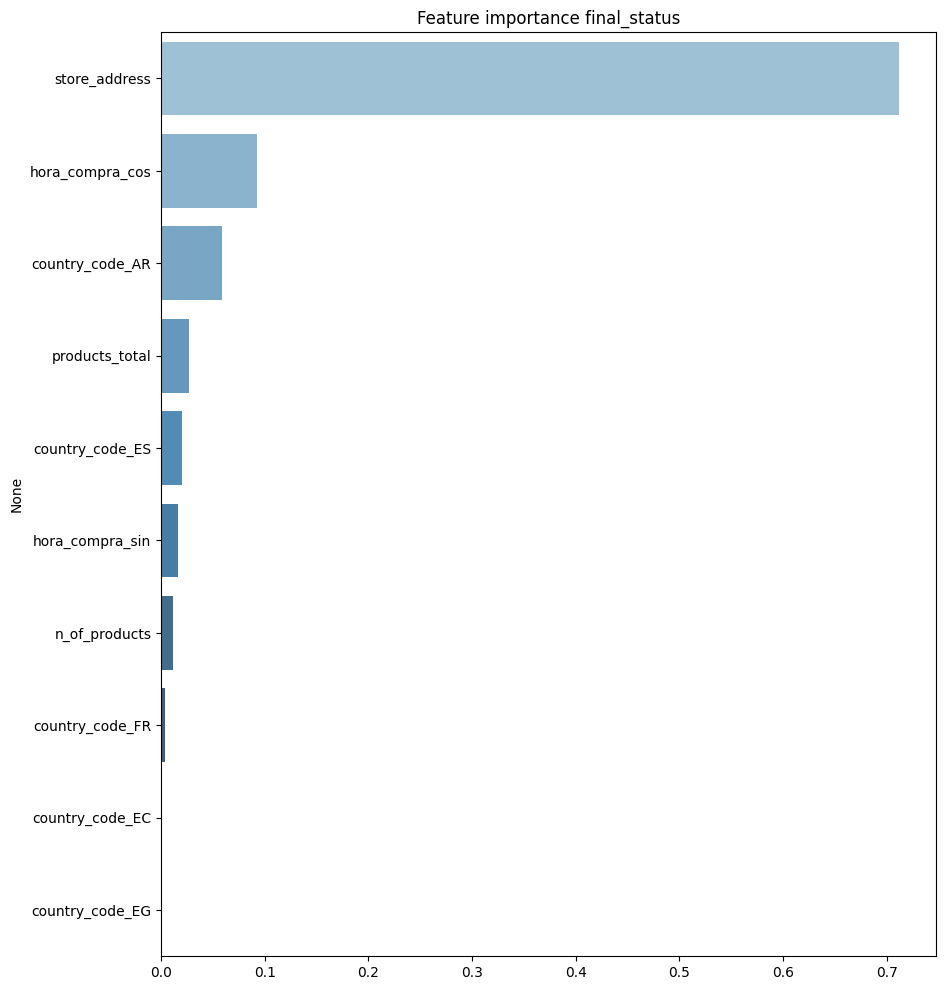

In [80]:
params = {'random_state': 42, 'n_jobs': 4, 'n_estimators': 100, 'max_depth': 4}

x, y = df.drop('final_status',axis=1), df['final_status']
# entrena un RandomForest Classifier
clf = RandomForestClassifier(**params)
clf = clf.fit(x, y)
# Plotea las 10 mejores Features importances
features = clf.feature_importances_[:10]
columnas = x.columns[:10]
imp = pd.Series(data=features, index=columnas).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance {}".format('final_status'))
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')
plt.show()

## SPLIT TRAIN/TEST

In [81]:
# Se guarda el target como "y" y las features como "X"
y = df["final_status"]
X = df.drop("final_status", axis=1)

# Se guarda un 30% de los datos para test y el 70% para train
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [82]:
X_train.shape

(8164, 19)

In [83]:
X_test.shape

(3500, 19)

## Estandarización

In [84]:
# Estandarizamos variables con StandarScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # estandariza y define la regla de estandarización
X_test = scaler.transform(X_test) # estandariza según la regla definida con el X_train, con la media de X_train

In [85]:
# Debemos poner las columnas del dataset de predicción en el mismo orden que el de entrenamiento con reindex
columnas_X_train = X.columns
df_pred = df_pred.reindex(columns=columnas_X_train)



In [86]:
# Estandarizamos las variables del dataset a predecir según la regla definida con el X_train
df_pred = scaler.transform(df_pred)


## Modelado

*   defino el modelo
*   entreno el dataset de train
*   predigo el dataset de test
*   analizo las métricas

In [87]:
def medicion(y_t, y_p):
  """imprime la curva ROC y el AUC"""

  # calculate the fpr and tpr for all thresholds of the classification
  fpr, tpr, threshold = metrics.roc_curve(y_t, y_p)
  roc_auc = metrics.auc(fpr, tpr)

  # para añadir el gráfico
  # method I: plt
  import matplotlib.pyplot as plt
  plt.figure(figsize=(8, 6))
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  return roc_auc

In [88]:
def entrenar(Xtrain, Xtest, ytrain, ytest):
  """entrena 6 módelos.
      imprime la curva roc de cada módelo junto al valor AUC
      devuelve un dataframe con los valores de AUC redondeados a 5 decimales para cada módelo"""

  # creamos la lista de auc vacía
  lista_aucs = []

  # Support Vector Machine
  print('Support Vector Machine')
  svclassifier = SVC(max_iter=20)

  svclassifier.fit(Xtrain, ytrain)
  y_pred = svclassifier.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('SVC', round(roc_auc, 5)))

  # Regresión logística
  print('Regresión logística')
  lr = LogisticRegression(max_iter=40)

  lr.fit(Xtrain, ytrain)
  y_pred = lr.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('regresión logística', round(roc_auc, 5)))

  # RidgeClassifier
  print('RidgeClassifier')
  rc = RidgeClassifier(max_iter=40)

  rc.fit(Xtrain, ytrain)
  y_pred = rc.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('RidgeClassifier', round(roc_auc, 5)))

  # Decision tree classsifier
  print('Decision tree classsifier')
  dt_base = DecisionTreeClassifier(random_state=42)

  dt_base.fit(Xtrain, ytrain)
  y_pred = dt_base.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('decision tree classifier', round(roc_auc, 5)))

  # Random forest
  print('Random forest')
  rf_base = RandomForestClassifier(random_state=42)

  rf_base.fit(Xtrain, ytrain)
  y_pred = rf_base.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('random forest', round(roc_auc, 5)))

  # Gradient boosting
  print('Gradient boosting')
  gbc_base = GradientBoostingClassifier(random_state=42)

  gbc_base.fit(Xtrain, ytrain)
  y_pred = gbc_base.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('gradient boosting', round(roc_auc, 5)))

  # XGBClassifier
  print('XGBClassifier')
  xgbc_base = XGBClassifier(random_state=42)

  xgbc_base.fit(Xtrain, ytrain)
  y_pred = xgbc_base.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('XGB classifier', round(roc_auc, 5)))

  # CatBoostClassifier
  print('CatBoostClassifier')
  cat_base = CatBoostClassifier(verbose=False, random_state=42)

  cat_base.fit(Xtrain, ytrain)
  y_pred = cat_base.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('CatBoost Classifier', round(roc_auc, 5)))

  df_aucs = pd.DataFrame(lista_aucs, columns=['modelos', 'AUC'])
  df_aucs = df_aucs.set_index('modelos')

  return df_aucs

Support Vector Machine


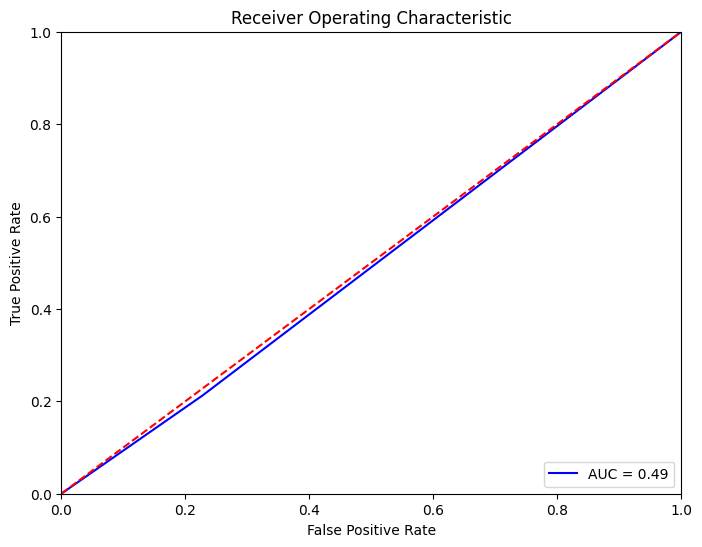

Regresión logística


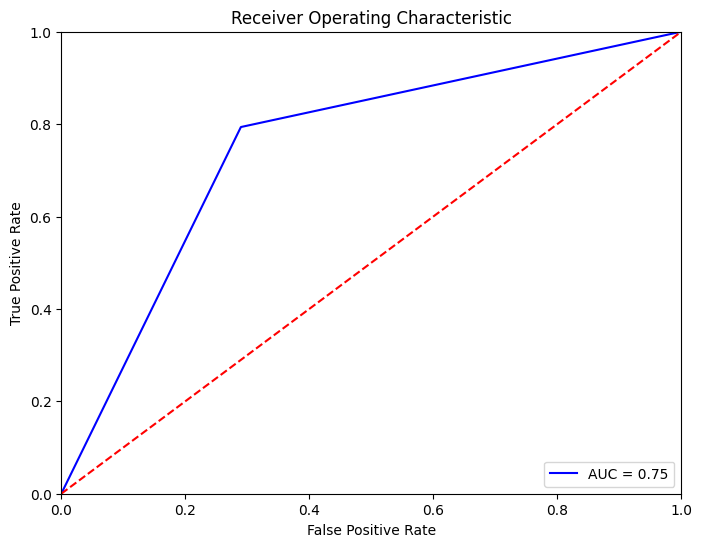

RidgeClassifier


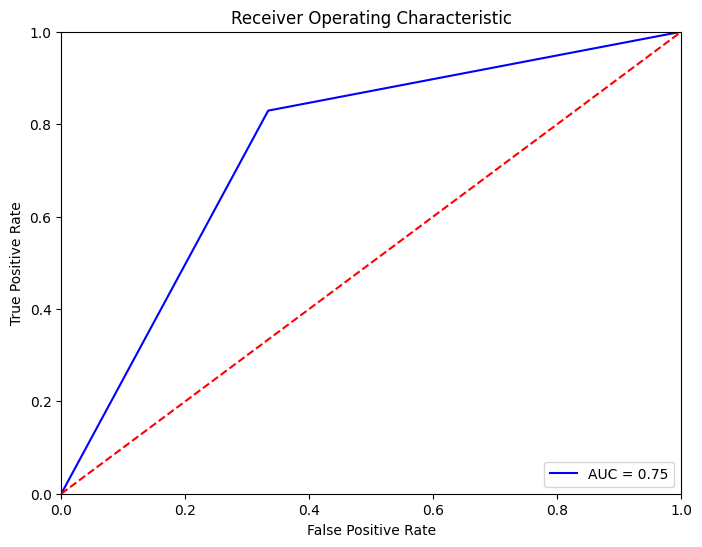

Decision tree classsifier


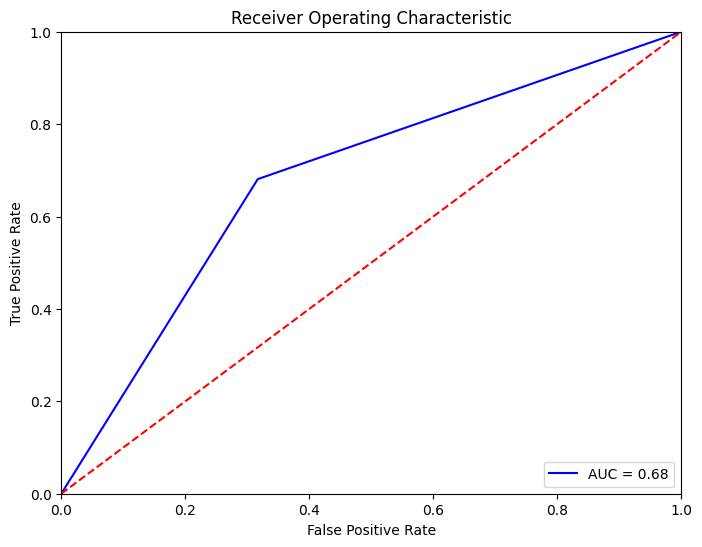

Random forest


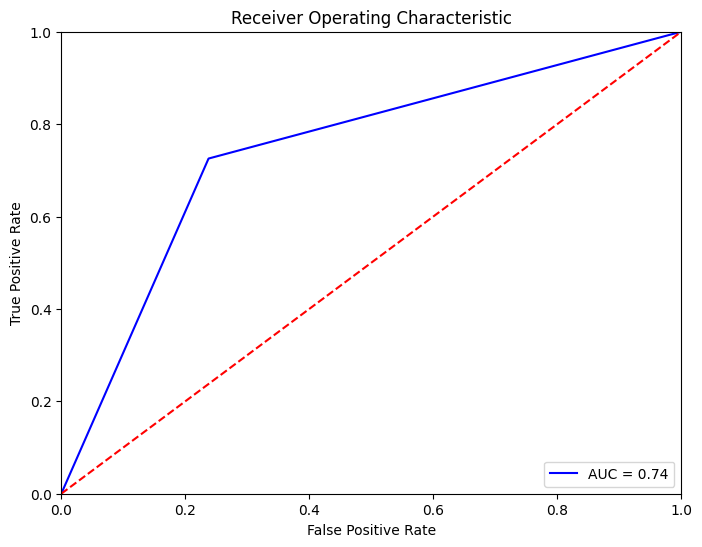

Gradient boosting


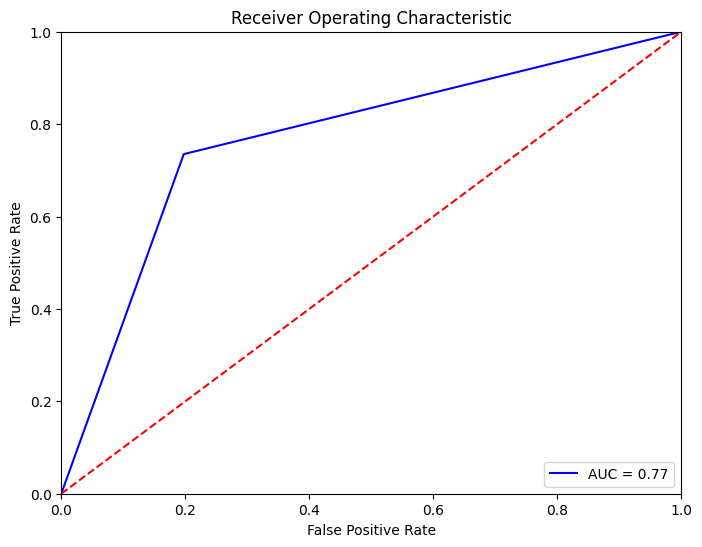

XGBClassifier


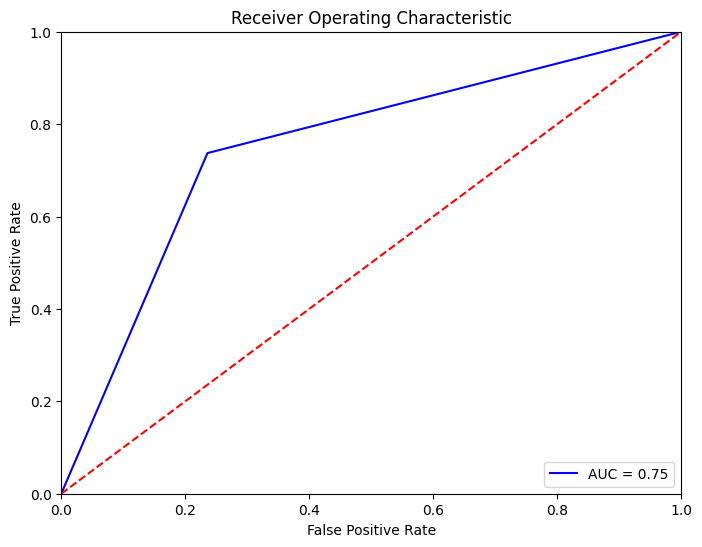

CatBoostClassifier


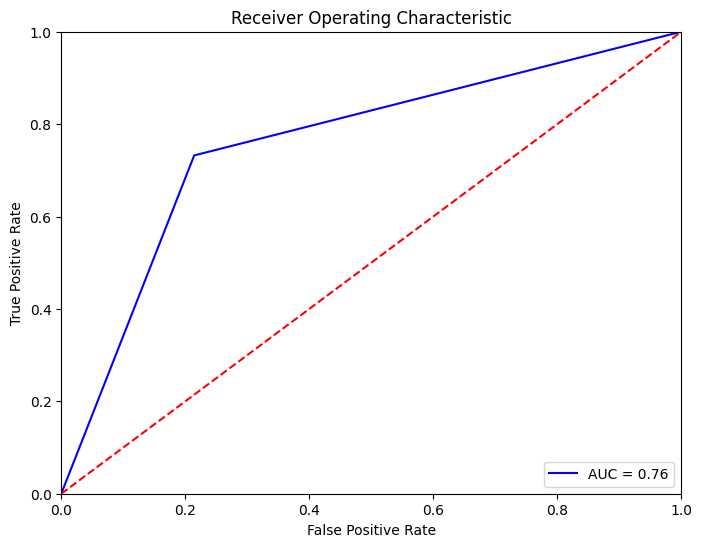

In [89]:
aucs = entrenar(X_train, X_test, y_train, y_test)

## MEDICIÓN

In [90]:
aucs

,AUC
modelos,
SVC,0.49241
regresión logística,0.75200
RidgeClassifier,0.74774
decision tree classifier,0.68201
random forest,0.74397
gradient boosting,0.76875
XGB classifier,0.75076
CatBoost Classifier,0.75894


## Hiperparametrización

In [91]:
# gridsearch
parameters = {'learning_rate': [0.03, 0.05, 0.1, 0.15],
              'n_estimators': [100, 300, 500],
              'max_depth': [3, 4, 5],
              'max_leaf_nodes': [None, 2, 3]}

In [92]:
gbc_hp =  GradientBoostingClassifier()

In [93]:
 gbc_grid = GridSearchCV(gbc_hp,
                         parameters,
                         cv=2,
                         verbose=True)
 gbc_grid.fit(X_train, y_train)

Fitting 2 folds for each of 108 candidates, totalling 216 fits


GridSearchCV(cv=2, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.03, 0.05, 0.1, 0.15],
                         'max_depth': [3, 4, 5], 'max_leaf_nodes': [None, 2, 3],
                         'n_estimators': [100, 300, 500]},
             verbose=True)

In [99]:
# se imprime el modelo con los mejores parametros
gbc_grid.best_estimator_

GradientBoostingClassifier(learning_rate=0.05, max_leaf_nodes=2,
                           n_estimators=500)

In [100]:
# se introducen los parametros del griedsearch
gbc = GradientBoostingClassifier(learning_rate=0.1, max_leaf_nodes=None, random_state=42)

gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

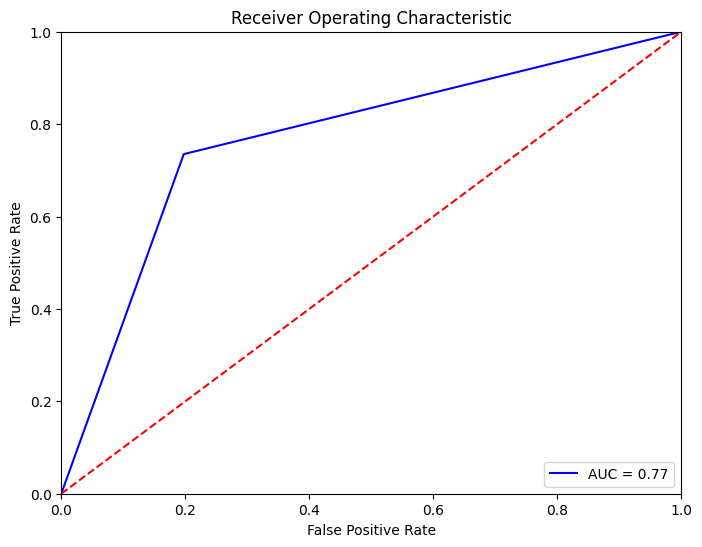

0.7687476893613296


In [101]:
roc_auc = medicion(y_test, y_pred)
print(roc_auc)

## PREDICCIÓN

In [102]:
# se hace la predicción con predict

pred = gbc.predict(df_pred)
pred

array([1, 0, 1, 1, 0, 1, 0, 0, 0, 1])

In [103]:
# se hace la predicción con la probabilidad para cada categoría con predict_proba

pred_proba = gbc.predict_proba(df_pred)
pred_proba

array([[0.14819025, 0.85180975],
       [0.89119985, 0.10880015],
       [0.13893953, 0.86106047],
       [0.1823799 , 0.8176201 ],
       [0.65197473, 0.34802527],
       [0.12586194, 0.87413806],
       [0.72168602, 0.27831398],
       [0.53611808, 0.46388192],
       [0.68194713, 0.31805287],
       [0.34357862, 0.65642138]])

In [104]:
pred_proba2 = []
for tupla in pred_proba:
  pred_proba2.append(tupla[1])
pred_proba2

[0.8518097519618844,
 0.1088001470791208,
 0.8610604716727485,
 0.8176200975235184,
 0.34802526501676345,
 0.874138055641684,
 0.27831397674826097,
 0.46388191924679323,
 0.31805286506502817,
 0.6564213837384172]

In [105]:
# creo un dataframe con mi predicción y las probabilidades
df_prediccion = pd.DataFrame()
df_prediccion['order_id'] = order_ids
df_prediccion['prediccion'] = pred
df_prediccion['prediccion_sin_redondeo'] = pred_proba2
df_prediccion

,order_id,prediccion,prediccion_sin_redondeo
0,32240990,1,0.851810
1,32960491,0,0.108800
2,32430153,1,0.861060
3,32777553,1,0.817620
4,32324328,0,0.348025
5,33047576,1,0.874138
6,33293677,0,0.278314
7,32073867,0,0.463882
8,32732256,0,0.318053
9,32152540,1,0.656421
